# Speech Command

In [1]:
import wave
import math
import time
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy import signal, fftpack
from scipy.io.wavfile import read


%matplotlib inline

## Building our sets

In [2]:
folder = "data/"

In [3]:
rossignol_set = []
rossignol_set.append({
    "filename": "enavant.wav",
    "class": "forward",
})
rossignol_set.append({
    "filename": "enavant2.wav",
    "class": "forward",
})
rossignol_set.append({
    "filename": "enavant3.wav",
    "class": "forward",
})
rossignol_set.append({
    "filename": "adroite.wav",
    "class": "right",
})
rossignol_set.append({
    "filename": "adroite2.wav",
    "class": "right",
})
rossignol_set.append({
    "filename": "adroite3.wav",
    "class": "right",
})
rossignol_set.append({
    "filename": "agauche.wav",
    "class": "left",
})
rossignol_set.append({
    "filename": "agauche2.wav",
    "class": "left",
})
rossignol_set.append({
    "filename": "agauche3.wav",
    "class": "left",
})
rossignol_set.append({
    "filename": "stop.wav",
    "class": "stop",
})
rossignol_set.append({
    "filename": "stop2.wav",
    "class": "stop",
})
rossignol_set.append({
    "filename": "stop3.wav",
    "class": "stop",
})

In [4]:
remi_set = []
remi_set.append({
    "filename": "enavant_1_remi.wav",
    "class": "forward",
})
remi_set.append({
    "filename": "enavant_2_remi.wav",
    "class": "forward",
})
remi_set.append({
    "filename": "enavant_3_remi.wav",
    "class": "forward",
})
remi_set.append({
    "filename": "adroite_1_remi.wav",
    "class": "right",
})
remi_set.append({
    "filename": "adroite_2_remi.wav",
    "class": "right",
})
remi_set.append({
    "filename": "adroite_3_remi.wav",
    "class": "right",
})
remi_set.append({
    "filename": "agauche_1_remi.wav",
    "class": "left",
})
remi_set.append({
    "filename": "agauche_2_remi.wav",
    "class": "left",
})
remi_set.append({
    "filename": "agauche_3_remi.wav",
    "class": "left",
})
remi_set.append({
    "filename": "stop_1_remi.wav",
    "class": "stop",
})
remi_set.append({
    "filename": "stop_2_remi.wav",
    "class": "stop",
})
remi_set.append({
    "filename": "stop_3_remi.wav",
    "class": "stop",
})

In [5]:
paul_set = []
paul_set.append({
    "filename": "enavant_1_paul.wav",
    "class": "forward",
})
paul_set.append({
    "filename": "enavant_2_paul.wav",
    "class": "forward",
})
paul_set.append({
    "filename": "enavant_3_paul.wav",
    "class": "forward",
})
paul_set.append({
    "filename": "adroite_1_paul.wav",
    "class": "right",
})
paul_set.append({
    "filename": "adroite_2_paul.wav",
    "class": "right",
})
paul_set.append({
    "filename": "adroite_3_paul.wav",
    "class": "right",
})
paul_set.append({
    "filename": "agauche_1_paul.wav",
    "class": "left",
})
paul_set.append({
    "filename": "agauche_2_paul.wav",
    "class": "left",
})
paul_set.append({
    "filename": "agauche_3_paul.wav",
    "class": "left",
})
paul_set.append({
    "filename": "stop_1_paul.wav",
    "class": "stop",
})
paul_set.append({
    "filename": "stop_2_paul.wav",
    "class": "stop",
})
paul_set.append({
    "filename": "stop_3_paul.wav",
    "class": "stop",
})

In [6]:
simon_set = []
simon_set.append({
    "filename": "enavant_1_simon.wav",
    "class": "forward",
})
simon_set.append({
    "filename": "enavant_2_simon.wav",
    "class": "forward",
})
simon_set.append({
    "filename": "enavant_3_simon.wav",
    "class": "forward",
})

## Defining the processing

In [7]:
def apply_preemphasis_filter(data_signal):
    # Pre-Emphasis Filter
    pre_emphasis = 0.95
    emphasized_signal = np.append(data_signal[0], data_signal[1:] - pre_emphasis * data_signal[:-1])
    return emphasized_signal

In [8]:
def apply_stft(data_signal, nperseg, overlap, fs, NFFT):
    # FFT
    window = 'hamming'
    f, t, Zxx = signal.stft(x = data_signal, fs=fs, nperseg=nperseg, noverlap=overlap, nfft=NFFT, window=window)
    return f, t, Zxx

In [9]:
def apply_filter_banks(Zxx, fs, NFFT):
    # Filter Banks
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / fs)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(Zxx.T, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    return filter_banks

In [51]:
def apply_mfcc(filter_banks):
    # MFCC
    num_ceps = 12
    mfcc = fftpack.dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    return mfcc

In [52]:
def clean_silence(a):
    first_voiced = -1
    last_voiced = -1
    length_frames = 100
    idx = 0
    for i in range(0,math.floor(len(a)/length_frames)):
        if (i+1) * length_frames > len(a):
            max_range = len(a) - 1
        else:
            max_range = (i+1) * length_frames
        frame = a[i*length_frames:max_range]
        local_mean = sum(frame) / len(frame)
        local_var = math.sqrt(sum((frame - local_mean)**2) / len(frame))
        if abs(local_var) > 300:
            if first_voiced == -1:
                first_voiced = idx * length_frames
            if last_voiced != -1:
                last_voiced = -1
        else:
            if last_voiced == -1:
                last_voiced = max_range
        idx = idx + 1
    return [first_voiced, last_voiced]   

In [64]:
def process_file(filename):
    [fs, a] = read(filename)
    nperseg = math.floor(fs*2/100)
    overlap = math.floor(nperseg/2)
    NFFT = 2*nperseg
    data_signal = np.array(a,dtype=float)
    data_signal = apply_preemphasis_filter(data_signal)
    f, t, Zxx = apply_stft(data_signal, nperseg, overlap, fs, NFFT)
    filter_banks = apply_filter_banks(Zxx, fs, NFFT)
    mfcc = apply_mfcc(filter_banks)
    plt.figure()
    plt.ylabel('Fréquence')
    plt.xlabel('Temps')
    plt.pcolormesh(np.abs(mfcc))
    return mfcc

In [54]:
def altDTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= np.sqrt(sum(np.abs((s1[i]-s2[j])**2)))
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return DTW[len(s1)-1, len(s2)-1]

In [55]:
def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= np.sqrt(sum(np.abs((s1[i]-s2[j]))**2))
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return DTW[len(s1)-1, len(s2)-1]

In [56]:
def diff_mfcc(s1, s2):
    diff = []
    for i in range(0, min(len(s1), len(s2))):
        current_diff = s1[i] - s2[i]
        diff.append(current_diff)
    plt.pcolormesh(np.real(diff))
    plt.show()

In [57]:
def get_k_nn(distance, k):
    classes = [0, 0, 0, 0]
    for i in range(k):
        minDist = {'dist': 1000000000}
        for j in range(len(distance)):
            dist = distance[j]['dtw']
            if dist == 0:
                continue
            elif dist < minDist.get('dist'):
                minDist = {'dist': dist, 'class': distance[j]['class'], 'idx': j}
        distance.pop(minDist.get('idx'))
        if minDist.get('class') == 'forward':
            classes[0] = classes[0] + 1
        elif minDist.get('class') == 'right':
            classes[1] = classes[1] + 1
        elif minDist.get('class') == 'left':
            classes[2] = classes[2] + 1
        elif minDist.get('class') == 'stop':
            classes[3] = classes[3] + 1
    return classes

In [58]:
def compute_set(folder, files):
    for fileIdx in range(len(files)):
        filename = files[fileIdx].get('filename')
        mfcc = process_file(folder + filename)
        files[fileIdx]['mfcc'] = mfcc
    return files

In [59]:
def test_set_to_reference(test_set, reference_set, verbose=False):
    good_predictions = [0,0,0,0]
    for fileIdx1 in range(len(test_set)):
        file1 = test_set[fileIdx1]
        dtw_distance = []
        for fileIdx2 in range(len(reference_set)):
            file2 = reference_set[fileIdx2]
            dtw_distance.append({'class': file2.get('class'), 'dtw': altDTWDistance(file1.get('mfcc'), file2.get('mfcc'), 15)})
        if verbose:
            print(file1.get('filename') + ':')
        classes = get_k_nn(dtw_distance, 1)
        if(max(classes) == classes[0]):
            if(file1.get('class') == 'forward'):
                if verbose:
                    print('TRUE')
                good_predictions[0] += 1
            else:
                if verbose:
                    print('FALSE')
            test_set[fileIdx1]['prediction'] = 'forward'
        elif(max(classes) == classes[1]):
            if(file1.get('class') == 'right'):
                if verbose:
                    print('TRUE')
                good_predictions[1] += 1
            else:
                if verbose:
                    print('FALSE')
            test_set[fileIdx1]['prediction'] = 'right'
        elif(max(classes) == classes[2]):
            if(file1.get('class') == 'left'):
                if verbose:
                    print('TRUE')
                good_predictions[2] += 1
            else:
                if verbose:
                    print('FALSE')
            test_set[fileIdx1]['prediction'] = 'left'
        elif(max(classes) == classes[3]):
            if(file1.get('class') == 'stop'):
                if verbose:
                    print('TRUE')
                good_predictions[3] += 1
            else:
                if verbose:
                    print('FALSE')
            test_set[fileIdx1]['prediction'] = 'stop'   
        if verbose:
            print(classes)
    print('\nGood Predictions:')
    print(good_predictions)
    print('\nAccuracy:')
    print(str(math.floor(sum(good_predictions)/(len(test_set))*100)) + '%')
    return test_set

## Evaluating multiple datasets

In [60]:
# Evaluate the dataset over itself
reference_set = rossignol_set + remi_set + paul_set
reference_set = compute_set(folder=folder, files=reference_set)
reference_set = test_set_to_reference(test_set=reference_set, reference_set=reference_set, verbose=False)


Good Predictions:
[8, 5, 7, 8]

Accuracy:
77%


In [61]:
# Test Rémi
reference_set = compute_set(folder=folder, files=paul_set+rossignol_set)
test_set = compute_set(folder=folder, files=remi_set)
test_set = test_set_to_reference(test_set=test_set, reference_set=reference_set, verbose=False)


Good Predictions:
[3, 2, 3, 3]

Accuracy:
91%


In [62]:
# Test Paul
reference_set = compute_set(folder=folder, files=remi_set+rossignol_set)
test_set = compute_set(folder=folder, files=paul_set)
test_set = test_set_to_reference(test_set=test_set, reference_set=reference_set, verbose=False)


Good Predictions:
[3, 3, 0, 3]

Accuracy:
75%


In [63]:
# Test Simon
reference_set = compute_set(folder=folder, files=paul_set+remi_set+rossignol_set)
test_set = compute_set(folder=folder, files=simon_set)
test_set = test_set_to_reference(test_set=test_set, reference_set=reference_set, verbose=False)


Good Predictions:
[3, 0, 0, 0]

Accuracy:
100%


## Evaluating the duration of the classification

In [25]:
reference_set = compute_set(folder=folder, files=paul_set+remi_set+rossignol_set)
test_set = compute_set(folder=folder, files=[simon_set[0]])

In [26]:
t1 = time.time()
test_set = test_set_to_reference(test_set=test_set, reference_set=reference_set, verbose=False)
t2 = time.time()
print("Processed in " + str(t2-t1) + " seconds.")


Good Predictions:
[1, 0, 0, 0]

Accuracy:
100%
Processed in 0.5815889835357666 seconds.


## Voice Activity Detection

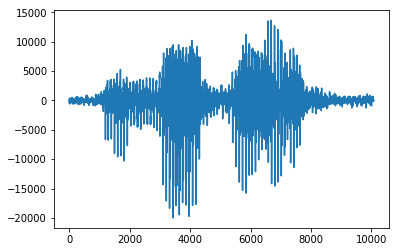

In [227]:
[fs, a] = read('data/enavant.wav')
plt.plot(a)

In [221]:
signal_clean = []
first_voiced = -1
last_voiced = -1
idx = 0
length_frames = math.floor(30 * fs/1000)
for i in range(0,math.floor(len(a)/length_frames)):
    if (i+1) * length_frames > len(a):
        max_range = len(a) - 1
    else:
        max_range = (i+1) * length_frames
    frame = a[i*length_frames:max_range]
    local_mean = sum(frame) / len(frame)
    local_var = math.sqrt(sum((frame - local_mean)**2) / len(frame))
    if abs(local_var) > 500:
        signal_clean.extend(frame)
        if first_voiced == -1:
            first_voiced = idx * length_frames
        if last_voiced != -1:
            last_voiced = -1
    else:
        signal_clean.extend(np.zeros(length_frames))
        if last_voiced == -1:
            last_voiced = max_range
    idx = idx + 1

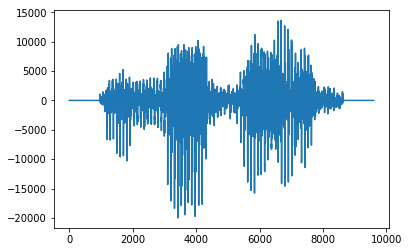

In [222]:
plt.plot(signal_clean)

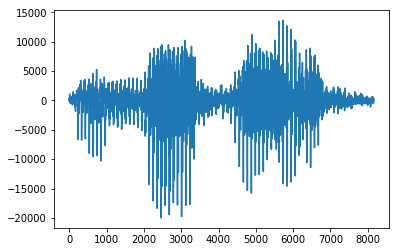

In [223]:
signal_clean = a[first_voiced:last_voiced]
plt.plot(signal_clean)


## Pipeline

- Segmentation du son en frames de x.x secondes
- Voice activity detection sur la frame
- Reconstruction du signal


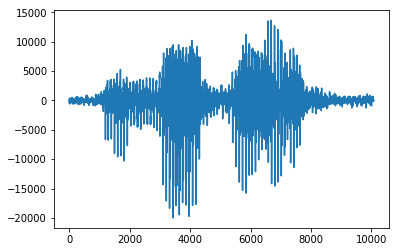

In [228]:
[fs_noise, noise] = read('data/noise.wav')
plt.plot(a)

In [229]:
def is_noise(frame):
    local_mean = sum(frame) / len(frame)
    local_var = math.sqrt(sum((frame - local_mean)**2) / len(frame))
    if abs(local_var) > 1000:
        return False
    return True

def simulate_real_time(signals):
    signal_clean = []
    first_voiced = -1
    last_voiced = -1
    idx = 0
    for [signal, frequency] in signals:
        length_frames = math.floor(30 * frequency/1000)
        for i in range(0,math.floor(len(a)/length_frames)):
        if (i+1) * length_frames > len(a):
            max_range = len(a) - 1
        else:
            max_range = (i+1) * length_frames

In [225]:
signal_clean = []
first_voiced = -1
last_voiced = -1
idx = 0
length_frames = math.floor(30 * fs/1000)
for i in range(0,math.floor(len(a)/length_frames)):
    if (i+1) * length_frames > len(a):
        max_range = len(a) - 1
    else:
        max_range = (i+1) * length_frames
    frame = a[i*length_frames:max_range]
    local_mean = sum(frame) / len(frame)
    local_var = math.sqrt(sum((frame - local_mean)**2) / len(frame))
    if abs(local_var) > 1000:
        signal_clean.extend(frame)
        if first_voiced == -1:
            first_voiced = idx * length_frames
        if last_voiced != -1:
            last_voiced = -1
    else:
        signal_clean.extend(np.zeros(length_frames))
        if last_voiced == -1:
            last_voiced = max_range
    idx = idx + 1
    

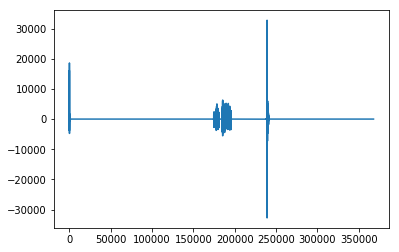

In [226]:
plt.plot(signal_clean)